# House Price Prediction - Melwyn D Souza (MSc. AI)

Importing neccessary libraries

In [69]:
import pandas as pd
import numpy as np
import sklearn, copy, math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#importing models
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

%matplotlib inline

Reading data from train and test csv files 

In [70]:
traindata = pd.read_csv("train.csv")
testdata = pd.read_csv("test.csv")
# print("************** TRAIN DATA ****************")
# print(traindata.head())
# print("\n\n************** TEST DATA ****************")
# print(testdata.head())
traindata

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5
...,...,...,...,...,...,...,...,...,...,...,...,...
29446,Owner,0,0,3,BHK,2500.000000,1,1,"Shamshabad Road,Agra",27.140626,78.043277,45.0
29447,Owner,0,0,2,BHK,769.230769,1,1,"E3-108, Lake View Recidency,,Vapi",39.945409,-86.150721,16.0
29448,Dealer,0,0,2,BHK,1022.641509,1,1,"Ajmer Road,Jaipur",26.928785,75.828002,27.1
29449,Owner,0,0,2,BHK,927.079009,1,1,"Sholinganallur,Chennai",12.900150,80.227910,67.0


In [71]:
# print("************** TRAIN DATA INFO ****************")
# print(traindata.info())

# print("\n\n************** TEST DATA INFO ****************")
# print(testdata.info())

#from info I can see three columns to be categorical, address is not usefull, ill drop it, rest should be coverted
#using one-hot-encoder

#display 5 point summary, including freq, mean median 25% 50% 75% max min etc
# traindata.describe(include = 'all')

## Pre-process

In [72]:
#checking the data for any missing values
def pre_process(data):
    
    """Dealing with missing values"""
    
    print("\n----------Dealing with missing values-------------\n")
    if (data.isnull().sum().sum() > 0):
        print("This one has missing valuess")
        data = data.dropna()
        
        print(data.isnull().sum())
    
    """Dropping unwanted columns"""
    
    #dropping address column
    data.drop('ADDRESS', axis='columns', inplace=True)    
    
    """Delaing with categorical values"""
    print("\n---------Delaing with categorical values----------\n")
    print(data.head())

    df1 = pd.get_dummies(data["POSTED_BY"], prefix='POSTED_BY')
    data = pd.concat([data,df1],axis=1)
    data = data.drop(['POSTED_BY'],axis=1)
        
    df1 = pd.get_dummies(data["BHK_OR_RK"], prefix='Type')
    data = pd.concat([data,df1],axis=1)
    data = data.drop(['BHK_OR_RK'],axis=1)
    
    X = data.drop(['TARGET(PRICE_IN_LACS)'],axis=1)
    y = data['TARGET(PRICE_IN_LACS)'].astype(float) 
    
#     print(X.columns)
    print("\nOne hot encoded 'Posted_by' and 'BHK_RK'")
    print(X.head())
#     print(y.head())
    
    """Normalizing Data"""
    
    print("\n----------Normalizing Data------------\n")
    
    #I will noramlize/scale the data
    #Only bhk_no, longitude, lattitude and square_feet are normalized
    col_names = ['BHK_NO.','SQUARE_FT', 'LONGITUDE', 'LATITUDE']
    scaled_features = copy.deepcopy(X[col_names])
    std = StandardScaler()
    X_scaled = std.fit_transform(scaled_features.values)
    X[col_names] = X_scaled
    print(X.head())
    
    #Confirming if Standard scaler is making mean = 0 and std = 1
    print("\nIf the data is scaled right, mean will be 0 and standard deviation will be 1")
    print("Mean -> ",(X_scaled.mean(axis=0)).round())
    print("Standard Deviaition -> ",(X_scaled.std(axis=0)).round())

    """Dealing with Outliers"""
    
#     print("\n----------------Dealing with Outliers---------------\n")
#     #dealing with outliers
#     fig, ax = plt.subplots(2,2)
    
#     ax[0,0].boxplot(X["SQUARE_FT"])
#     ax[0,0].title.set_text("SQUARE_FT")
    
#     ax[0,1].boxplot(X["LONGITUDE"])
#     ax[0,1].title.set_text("LONGITUDE")
    
#     ax[1,0].boxplot(X["LATITUDE"])
#     ax[1,0].title.set_text("LATITUDE")
    
#     ax[1,1].boxplot(X["BHK_NO."])
#     ax[1,1].title.set_text("BHK_NO.")
#     plt.show()
    
#     print("Before dealing with outliers, X shape -> ",X.shape)    
    
    #Dealing with Outliers
    clf = IsolationForest(contamination=0.1).fit(X) #create Isolation Forest object
    result = clf.predict(X) #Finding outliers, returns array of 1 (non outliers) and -1 (outliers)
    X = X[result==1] #filter all good instances
    y = y[result==1]
    
#     print("After dealing with outliers, X shape -> ",X.shape)
    
#     #dealing with outliers
#     fig1, ax1 = plt.subplots(2,2)
    
#     ax1[0,0].boxplot(X["SQUARE_FT"])
#     ax1[0,0].title.set_text("SQUARE_FT")
    
#     ax1[0,1].boxplot(X["LONGITUDE"])
#     ax1[0,1].title.set_text("LONGITUDE")
    
#     ax1[1,0].boxplot(X["LATITUDE"])
#     ax1[1,0].title.set_text("LATITUDE")
    
#     ax1[1,1].boxplot(X["BHK_NO."])
#     ax1[1,1].title.set_text("BHK_NO.")
#     plt.show()
    
    """Feature Selection"""
    print("\n---------Feature Selection----------\n")

    forest = RandomForestRegressor(n_estimators =250, random_state = 0)
    forest.fit(X,y)
    importances = forest.feature_importances_
#     print(X.shape)
#     print(importances)
    for index,feature in zip(range(len(X.columns)), X.columns):
        print("Feature->"+str(feature)+" Importance-> "+str(importances[index]))
    
    #Note - always use (-array) if you need sorting in descending order
    idx = (-importances).argsort()
    
    plt.barh(X.columns[idx], importances[idx])
    plt.title("Feature Importances")
    plt.show()
    
    X = X.iloc[:,idx[0:8]]

#     print("\nAfter selecting 9 most important features")
#     plt.barh(X.columns, importances[idx[0:8]])
#     plt.title("Feature Importances")
#     plt.show()
    
# #     print(X.columns)
#     print(X.shape)
    
    return X,y
    


----------Dealing with missing values-------------


---------Delaing with categorical values----------

  POSTED_BY  UNDER_CONSTRUCTION  RERA  BHK_NO. BHK_OR_RK    SQUARE_FT  \
0     Owner                   0     0        2       BHK  1300.236407   
1    Dealer                   0     0        2       BHK  1275.000000   
2     Owner                   0     0        2       BHK   933.159722   
3     Owner                   0     1        2       BHK   929.921143   
4    Dealer                   1     0        2       BHK   999.009247   

   READY_TO_MOVE  RESALE  LONGITUDE   LATITUDE  TARGET(PRICE_IN_LACS)  
0              1       1  12.969910  77.597960                   55.0  
1              1       1  12.274538  76.644605                   51.0  
2              1       1  12.778033  77.632191                   43.0  
3              1       1  28.642300  77.344500                   62.5  
4              0       1  22.592200  88.484911                   60.5  

One hot encoded 'Poste

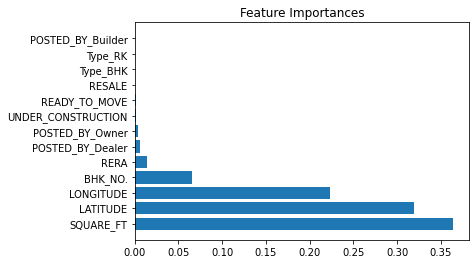

In [73]:
X, y = pre_process(traindata)


In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(21205, 8) (5302, 8) (21205,) (5302,)


In [75]:
def test_models(X_train, X_test, y_train, y_test):
    models = [LinearRegression(), DecisionTreeRegressor(), SVR(), Lasso(), RandomForestRegressor()]
    
    model_scores= {}
    
    
    for model in models:
        mdl = model.fit(X_train, y_train)
        y_preds = mdl.predict(X_test)
        rmse = math.sqrt(mean_squared_error(y_test, y_preds))
        
        print(model)
        plt.plot(X_test[0:1000],y_test[0:1000], 'g')
        plt.plot(X_test[0:1000],y_preds[0:1000], 'r')
        plt.show()

#         for i,j in zip(y_test[0:20], y_preds[0:20]):
#             print(i,j)
        
        model_scores[model] = rmse
#         scores.append(f1Score)
#         names.append(type(model).__name__)

#     model_scores =  dict(sorted(model_scores.items(),reverse=True, key=lambda item: item[1]))
#     print(model_scores)
    
#     #print confusion matrix and classification report for 3 best performing models 
#     for i in range (3):
#         temp = list(model_scores.items())[i]
#         best_models.append(temp[0])
#         print("Rank {} model is {} with f1 score of {}".format(i, temp[0], temp[1]))
#         print("Confusion matrix is as shown below\n")
#         preds = temp[0].predict(test_features)
#         print(confusion_matrix(test_labels, preds))
#         print(classification_report(test_labels, preds))
   
#     return best_models,names,scores
    
    print(model_scores)
    

LinearRegression()


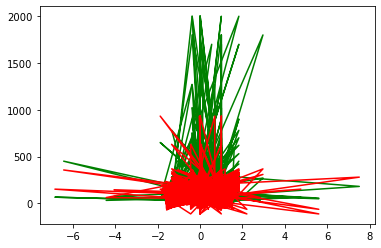

DecisionTreeRegressor()


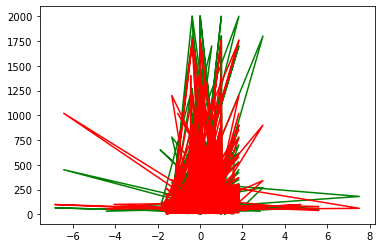

SVR()


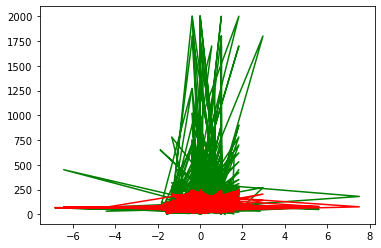

Lasso()


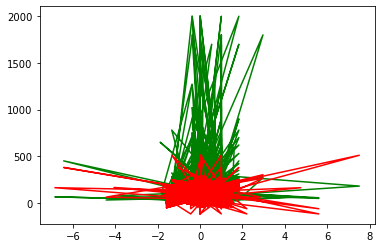

RandomForestRegressor()


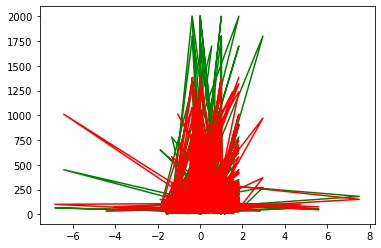

{LinearRegression(): 139.60384937911164, DecisionTreeRegressor(): 132.1202194312773, SVR(): 130.56515797899277, Lasso(): 132.1355438967689, RandomForestRegressor(): 92.96168990754397}


In [76]:
test_models(X_train, X_test, y_train, y_test)